# Bitcoin Price Prediction using multiple Machine Learning Techniques

## Purpose
My father and I have been tracking cryptocurrency trends since the first large bitcoin boom. During an Data Analysis Methods class I wanted to see if I could create an price prediction model to predict future bitcoin price using techniques taught in class. We will be taking this a little further within this notebook by implementing an model that better fits price forecasting, Long Short-Term Memory (LSTM).

## Our Aim
The cryptocurrency market has been a significant point of interest in the past decade with Bitcoin leading the space. With a highly volatile market similar to many other securities, predicting Bitcoin's prices has proven to be a challenging task with substantial financial implications. In this project, we will attempt to create a predictive model for Bitcoin using the K-Nearest Neighbors algorithm alongside the Long Short-Term Memory algorithm, in order to identify coming bull or bear market trends.


| Techniques      | Explanation |
| ----------- | ----------- |
| K-Nearest Neighbors Regression (KNN)      | Basic KNN Regression done on a time series dataset.       |
| Long Short-Term Memory Regression (LSTM)    | Basic LSTM Regression done on a time series dataset.        |
| Features Scaling | Standardization or normalization of input features to improve KNN/LSTM performance.|
| Feature Selection | Choosing the optimal features for KNN and LSTM |

## Data Collection
We will be using historical data captured by CoinMarketCap hosted on Yahoo Finance \
[Dataset](https://finance.yahoo.com/quote/BTC-USD/history/)

| Variables of Interest      | Explanation |
| ----------- | ----------- |
| Date      | The date of observation       |
| Open   | The price of bitcoin when the market opens        |
| Close  | The price of bitcoin when the market opens|
| High | The highest price of bitcoin of the day|
| Low | The lowest price of bitcoin of the day|
| Volume | The amount of bitcoin sold in a day in dollars |

## Data Cleaning

In [1]:
# READ IN THE DATA SET HERE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import zscore

data = pd.read_csv('BTC-USD.csv', index_col="Date")
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500.0
2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700.0
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400.0


In [2]:
cleaned_data = pd.read_csv('BTC-USD.csv', index_col = "Date")

# Finding the daily Price Gap and Daily Range.
cleaned_data['Price Gap'] = cleaned_data['Open'] - cleaned_data['Close']
cleaned_data['Daily Range'] = cleaned_data['High'] - cleaned_data['Low']

# Not working with Adj Close so we will remove that column
del cleaned_data['Adj Close']

# Cleaning NaN values from the table
cleaned_data.loc[:, 'Daily Range'] = cleaned_data.loc[:, 'Daily Range'].fillna(-1)
cleaned_data = cleaned_data[cleaned_data['Daily Range'] != (-1)]

# Converting the Date index into datetime format
cleaned_data.index = pd.to_datetime(cleaned_data.index)

cleaned_data.head(10)

,Open,High,Low,Close,Volume,Price Gap,Daily Range
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,8.529999,15.752014
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,32.419983,43.755981
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,29.307007,43.302978
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,-14.230988,33.412994
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,9.263977,19.244995
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,-3.052002,9.785980
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,-33.698975,45.360016
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,12.546020,14.980011
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,11.582001,14.052002


We added two new columns into our dataset using the values found in it. Price Gap is the range between BTC's open price and close price. Daily Range is simply the range between the High and Low of BTC price in a day. We also removed the Adj Close column since we won't be using that in our project.

## Exploratory Data Analysis

In [3]:
cleaned_data.describe()

,Open,High,Low,Close,Volume,Price Gap,Daily Range
count,3590.000000,3590.000000,3590.000000,3590.000000,3.590000e+03,3590.000000,3590.000000
mean,17036.784047,17425.441079,16621.791254,17052.453562,1.735558e+10,-15.669515,803.649825
std,18911.965646,19338.776791,18443.187912,18922.089361,1.916708e+10,861.793933,1202.800963
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,-7309.636719,1.028000
25%,1062.914947,1095.687470,1042.132446,1065.249969,2.538033e+08,-125.558105,41.797660
50%,8905.078125,9152.231933,8708.710938,8902.201660,1.338389e+10,-1.464493,318.298584
75%,27989.750976,28466.857422,27371.723633,28023.754394,2.794229e+10,98.840576,1048.766601
max,73079.375000,73750.070313,71334.093750,73083.500000,3.509679e+11,7563.996094,12864.621094


#### Points of Interest  
* The dataset contains 3590 observations, ~10 years of data.

* Bitcoin on average fluctuates $803 within a day.

* Bitcoin on average went down $15.66 a day. (Not really true since bitcoin is so volatile)

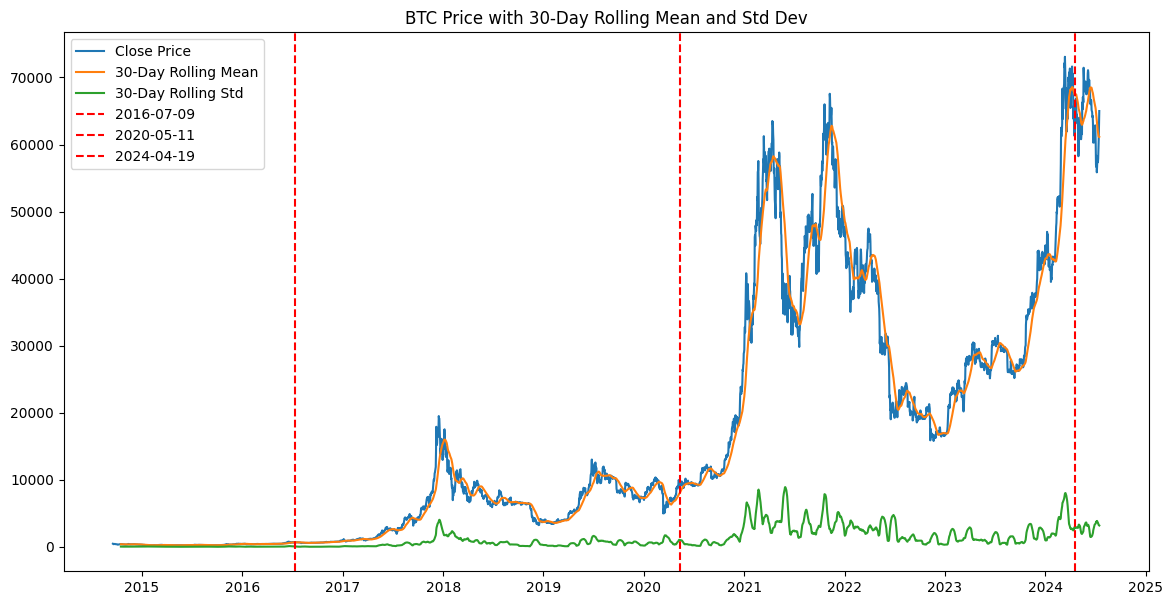

In [4]:
# Creating Rolling Mean/Std columns for time series data analysis
cleaned_data['Rolling Mean'] = cleaned_data['Close'].rolling(window=30).mean()
cleaned_data['Rolling Std'] = cleaned_data['Close'].rolling(window=30).std()

# Halving Dates
btc_halving_dates = ['2016-07-09', '2020-05-11', '2024-04-19']
btc_halving_dates = pd.to_datetime(btc_halving_dates)

# Plotting BTC Close price, Rolling Mean, and Rolling Std.
plt.figure(figsize=(14, 7))
plt.plot(cleaned_data.index, cleaned_data['Close'], label='Close Price')
plt.plot(cleaned_data.index, cleaned_data['Rolling Mean'], label='30-Day Rolling Mean')
plt.plot(cleaned_data.index, cleaned_data['Rolling Std'], label='30-Day Rolling Std')
# Adding vertical lines at the halving dates
for date in btc_halving_dates:
    plt.axvline(x=date, color='red', linestyle='--', label=date.strftime('%Y-%m-%d'))
plt.legend()
plt.title('BTC Price with 30-Day Rolling Mean and Std Dev')
plt.show()

This time series plot shows the close price for BTC over the past decade and the 30-day rolling mean and standard deviation of the close price. A rolling mean and standard deviation were chosen since we want to look at the central tendency and volatility over time.

#### Bitcoin Halving  
Before analyzing this graph, we need to explain a bitcoin halving. Bitcoin halving is a quadrennial event in which the amount of new Bitcoins created gets cut in half. Essentially, the reward for mining Bitcoin is reduced by 50%. This is done to limit the number of bitcoin mined by BTC miners since the amount of bitcoin that can be mined has a set limit of 21 million bitcoins. Bitcoin halving creates scarcity for the consumer, increasing the price. Each halving effectively makes the value of a singular bitcoin higher.

#### Visualization Analysis  
Historically, BTC prices peak within 12-18 months after a halving, which is proven according to the graph. However, as we can see, the current cycle started sooner than previous cycles, which is commonly attributed to social media. Prominent memes within the cryptocurrency space, such as Dogecoin and Shiba, have attracted large masses of people who created a cult following behind Bitcoin. An ever-increasing number of people trying to profit off these cryptocurrencies also leads to more front-running or buying before others. This can explain why cycles tend to occur quicker and quicker after every halving.

We can estimate the market's volatility at a given time by the standard deviation. One significant point on the graph is from 2021-2022, when prices fluctuate with a ton of volatility, as seen by the 30-day rolling standard deviation. This was due to the crypto market crash in 2021, which influenced BTC prices until late 2023.


### Creating RSI, SMA, and EMA  

| Terms      | Explanation |
| ----------- | ----------- |
| Relative Strength Index (RSI)      |  RSI is a measure of speed and magnitude of recent price changes. Typically an RSI >70 indicates the product is overvalued, and a RSI <30 indicates the product is undervalued.       |
| Simple Moving Average (SMA)   | SMA is a simple mean of the closing prices over a set number of days. An upwards slope indicates a bullish trend, whereas a downwards slope indicates a bearish trend.        |
| Exponential Moving Average (EMA) | EMA similar to SMA is a mean of the closing prices over a set number of days with weighted prices. More recent prices have a larger weight, making it more responsive to recent price changes. Interpretation is similar to SMA. |

In [5]:
# We will create a new dataframe containing the relevant variables using the cleaned dataset.
tech_data = cleaned_data.iloc[:, [0, 1, 2, 3, 4, 5]]
tech_data.head(10)

,Open,High,Low,Close,Volume,Price Gap
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,8.529999
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,32.419983
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,29.307007
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,-14.230988
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,9.263977
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,-3.052002
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,-33.698975
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,12.546020
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,11.582001


#### SMA

In [6]:
def calcSMA(df, window): # window is the number of days it is averaged by.
    df_temp = df.loc[:, 'Close'].rolling(window).mean()
    return df_temp

# Creating new SMA column
tech_data = tech_data.assign(SMA = tech_data.pipe(calcSMA,200)) # Window of 200 for visualization purposes.
tech_data.head(10)

,Open,High,Low,Close,Volume,Price Gap,SMA
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,8.529999,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,32.419983,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,29.307007,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,-14.230988,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,9.263977,NaN
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,-3.052002,NaN
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,-33.698975,NaN
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,12.546020,NaN
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,11.582001,NaN


#### EMA

In [7]:
def calcEMA(df, period, column_name):
    # Smoothing factor
    k = 2 / (period + 1)

    # Initialize the EMA list with the first price and calculate rest recursively
    ema = [df[column_name].iloc[0]]

    for price in df[column_name].iloc[1:]:
        new_ema = (price * k) + (ema[-1] * (1 - k))
        ema.append(new_ema) # Forum Fix

    df_temp = pd.Series(ema, index=df[column_name].index)

    return df_temp

# Creating new EMA column
tech_data = tech_data.assign(EMA = tech_data.pipe(calcEMA,200, 'Close')) # Window of 200 for visualization purposes
tech_data.head(10)

,Open,High,Low,Close,Volume,Price Gap,SMA,EMA
Date,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,8.529999,NaN,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,32.419983,NaN,457.006711
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,29.307007,NaN,456.387699
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,-14.230988,NaN,455.915225
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,9.263977,NaN,455.347123
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,-3.052002,NaN,454.817818
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,-33.698975,NaN,454.628497
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,12.546020,NaN,454.315825
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,11.582001,NaN,453.890533


#### RSI

In [8]:
def calcRSI(df, window):
    # Calculate daily price changes !-First row will be NaN values
    delta = df['Close'].diff()

    # Calculate gains and losses
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean() # uses same rolling method as in SMA to avoid loops
    avg_loss = loss.rolling(window=window).mean()

    # Calculate RSI
    rsi = 100 - (100 / (1 + avg_gain / avg_loss))

    df_temp = pd.Series(rsi, index=df['Close'].index)

    return df_temp

# Creating new RSI column
tech_data = tech_data.assign(RSI = tech_data.pipe(calcRSI,21)) # We will be using a window of 21 days for visualization purposes.

tech_data.head(10)

,Open,High,Low,Close,Volume,Price Gap,SMA,EMA,RSI
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,8.529999,NaN,457.334015,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,32.419983,NaN,457.006711,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,29.307007,NaN,456.387699,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,-14.230988,NaN,455.915225,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,9.263977,NaN,455.347123,NaN
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,-3.052002,NaN,454.817818,NaN
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,-33.698975,NaN,454.628497,NaN
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,12.546020,NaN,454.315825,NaN
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,11.582001,NaN,453.890533,NaN


#### SMA, EMA, RSI Visualization

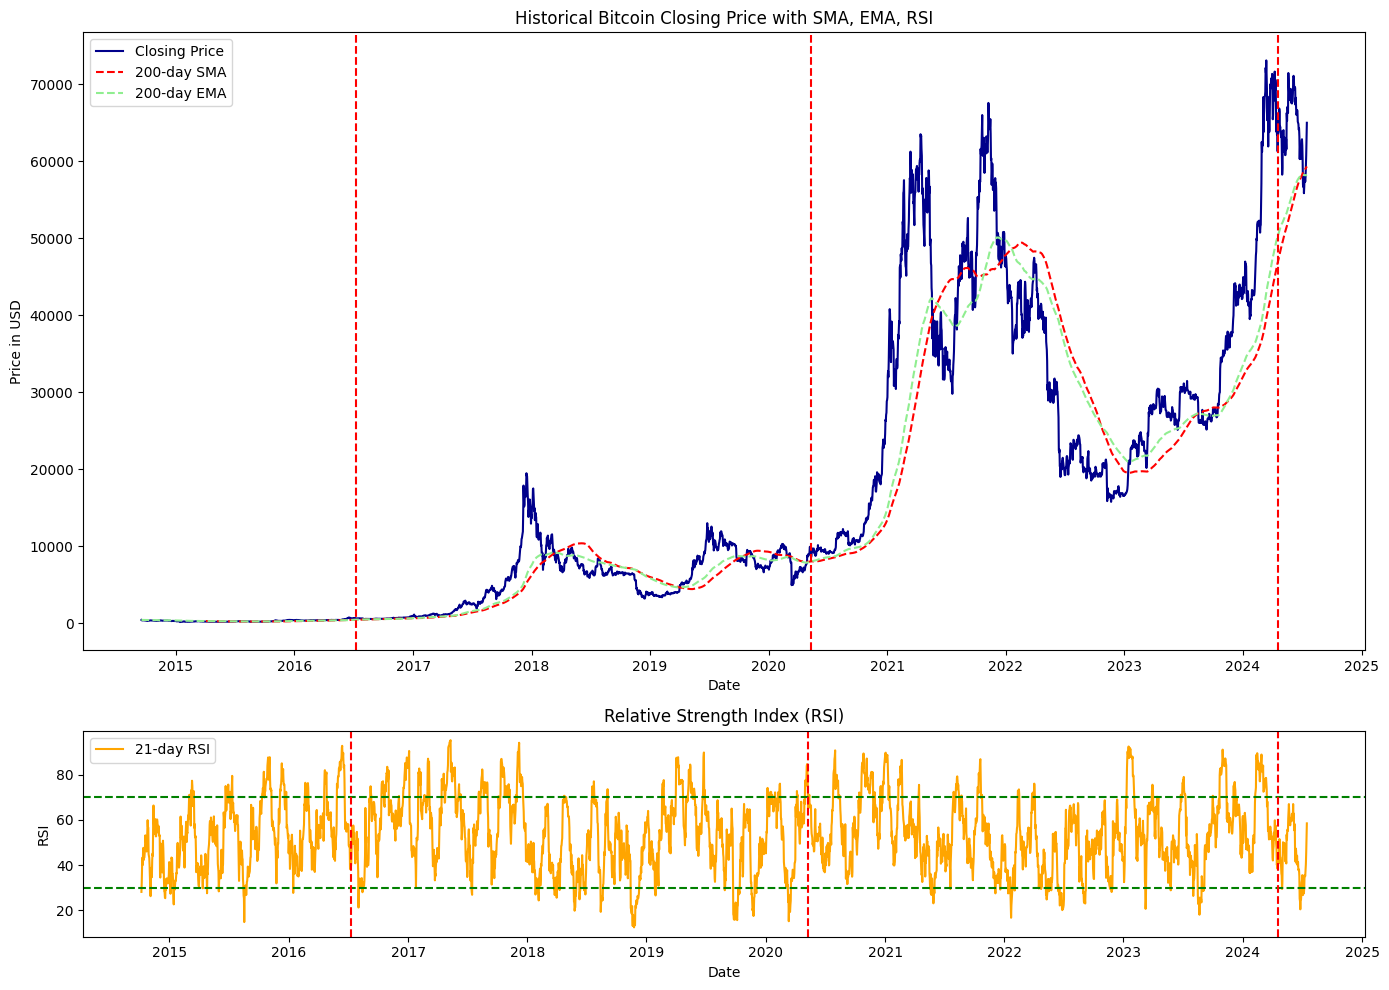

In [9]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

### Plot with Closing Price, SMA, EMA
ax1.plot(tech_data.index, tech_data['Close'], color = 'darkblue', label='Closing Price')
ax1.plot(tech_data.index, tech_data['SMA'], label='200-day SMA', color='red', linestyle='dashed')
ax1.plot(tech_data.index, tech_data['EMA'], label='200-day EMA', color='lightgreen', linestyle='dashed')

ax1.set_xlabel('Date')
ax1.set_ylabel('Price in USD')
ax1.set_title('Historical Bitcoin Closing Price with SMA, EMA, RSI')
ax1.legend()

# Adding vertical lines at the halving dates
for date in btc_halving_dates:
    ax1.axvline(x=date, color='red', linestyle='--', label=date.strftime('%Y-%m-%d'))


### Plot with RSI
ax2.plot(tech_data.index, tech_data['RSI'], label='21-day RSI', color='orange')

## Adding lines at significant values, 30 & 70.
ax2.axhline(y=70, color='green', linestyle='--')
ax2.axhline(y=30, color='green', linestyle='--')

ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_title('Relative Strength Index (RSI)')
ax2.legend()

# Adding vertical lines at the halving dates
for date in btc_halving_dates:
    ax2.axvline(x=date, color='red', linestyle='--', label=date.strftime('%Y-%m-%d'))


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Visualization Analysis  

As you can see, the SMA and EMA follow the actual prices; however, they are much smoother compared to the close prices as they show the long-term trend of the prices. This gives us more accurate trends, as frequent dips and jumps will not affect the predictions. The RSI graph also shows that Bitcoin usually stays within 30-70, and if it does stray from that range, the price readjusts within a few days.

### Calculating Stochastic Oscillator & MACD

| Terms      | Explanation |
| ----------- | ----------- |
| Stochastic Oscillator     |  The Stochastic Oscillator is a technical indicator that measures the momentum of a price trend. Similar to the RSI, levels near 0 indicate oversold conditions, and levels near 100 indicate overbought conditions.      |
| Moving Average Convergence Divergence (MACD)   | MACD is a technical indicator that can help identify market trends. When the MACD line goes above 0, it is considered bullish; when it is below 0, it is considered bearish. Secondly, when the MACD is larger than its signal (A 9-day EMA of the MACD), it signifies a bullish market, and when it is lesser, it signifies a bearish market.       |


#### MACD

In [10]:
EMA_12 = tech_data.pipe(calcEMA,12, 'Close')
EMA_26 = tech_data.pipe(calcEMA,26, 'Close')
tech_data['MACD'] = EMA_12 - EMA_26
tech_data = tech_data.assign(Signal = tech_data.pipe(calcEMA,9, 'MACD'))

tech_data.head(10)

,Open,High,Low,Close,Volume,Price Gap,SMA,EMA,RSI,MACD,Signal
Date,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,8.529999,NaN,457.334015,NaN,0.000000,0.000000
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,32.419983,NaN,457.006711,NaN,-2.624024,-0.524805
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,29.307007,NaN,456.387699,NaN,-7.014744,-1.822793
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,-14.230988,NaN,455.915225,NaN,-9.249402,-3.308115
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,9.263977,NaN,455.347123,NaN,-11.699137,-4.986319
2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,-3.052002,NaN,454.817818,NaN,-13.219400,-6.632935
2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500.0,-33.698975,NaN,454.628497,NaN,-11.576391,-7.621626
2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700.0,12.546020,NaN,454.315825,NaN,-11.161219,-8.329545
2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400.0,11.582001,NaN,453.890533,NaN,-11.636576,-8.990951


#### Stochastic Oscillator

In [11]:
# Calculate the rolling minimum
min = tech_data['Close'].rolling(window=14).min()

# Calculate the rolling maximum
max = tech_data['Close'].rolling(window=14).max()

# Calculate %K
tech_data['%K'] = 100 * ((tech_data['Close'] - min) / (max - min))

# Calculate %D (3-period SMA of %K)
tech_data['%D'] = tech_data['%K'].rolling(window=3).mean()

# Drop NA values created from rolling
tech_data.dropna(inplace = True)

tech_data.head(10)

,Open,High,Low,Close,Volume,Price Gap,SMA,EMA,RSI,MACD,Signal,%K,%D
Date,,,,,,,,,,,,,
2015-04-04,254.291000,255.257996,251.100006,253.697006,12493500.0,0.593994,310.843170,307.338692,38.216498,-4.193133,-3.906538,43.506205,43.417744
2015-04-05,253.761002,260.674988,251.942001,260.597992,19649200.0,-6.836990,309.859490,306.873610,39.428353,-3.252122,-3.775655,74.437092,54.641682
2015-04-06,260.721008,261.798004,254.574997,255.492004,20034200.0,5.229004,309.014750,306.362350,35.720502,-2.885117,-3.597547,71.450996,63.131431
2015-04-07,255.274002,255.804993,252.205002,253.179993,18467400.0,2.094009,308.306670,305.833173,36.545927,-2.749132,-3.427864,58.523897,68.137328
2015-04-08,253.063995,253.847000,244.214996,245.022003,30086400.0,8.041992,307.487260,305.228086,44.309309,-3.262042,-3.394700,12.910297,47.628397
2015-04-09,244.751007,246.117996,239.399994,243.675995,21643500.0,1.075012,306.711535,304.615628,40.995813,-3.734094,-3.462579,5.384391,25.606195
2015-04-10,243.694000,243.694000,232.770996,236.072006,28882000.0,7.621994,305.881135,303.933602,37.484770,-4.667968,-3.703656,0.000000,6.098229
2015-04-11,236.016006,239.537003,234.175003,236.552002,16365200.0,-0.535996,304.884940,303.263138,38.418575,-5.308149,-4.024555,1.957092,2.447161
2015-04-12,236.535004,237.727997,233.494995,236.153000,12387900.0,0.382004,303.949680,302.595375,33.045850,-5.781052,-4.375854,0.330237,0.762443


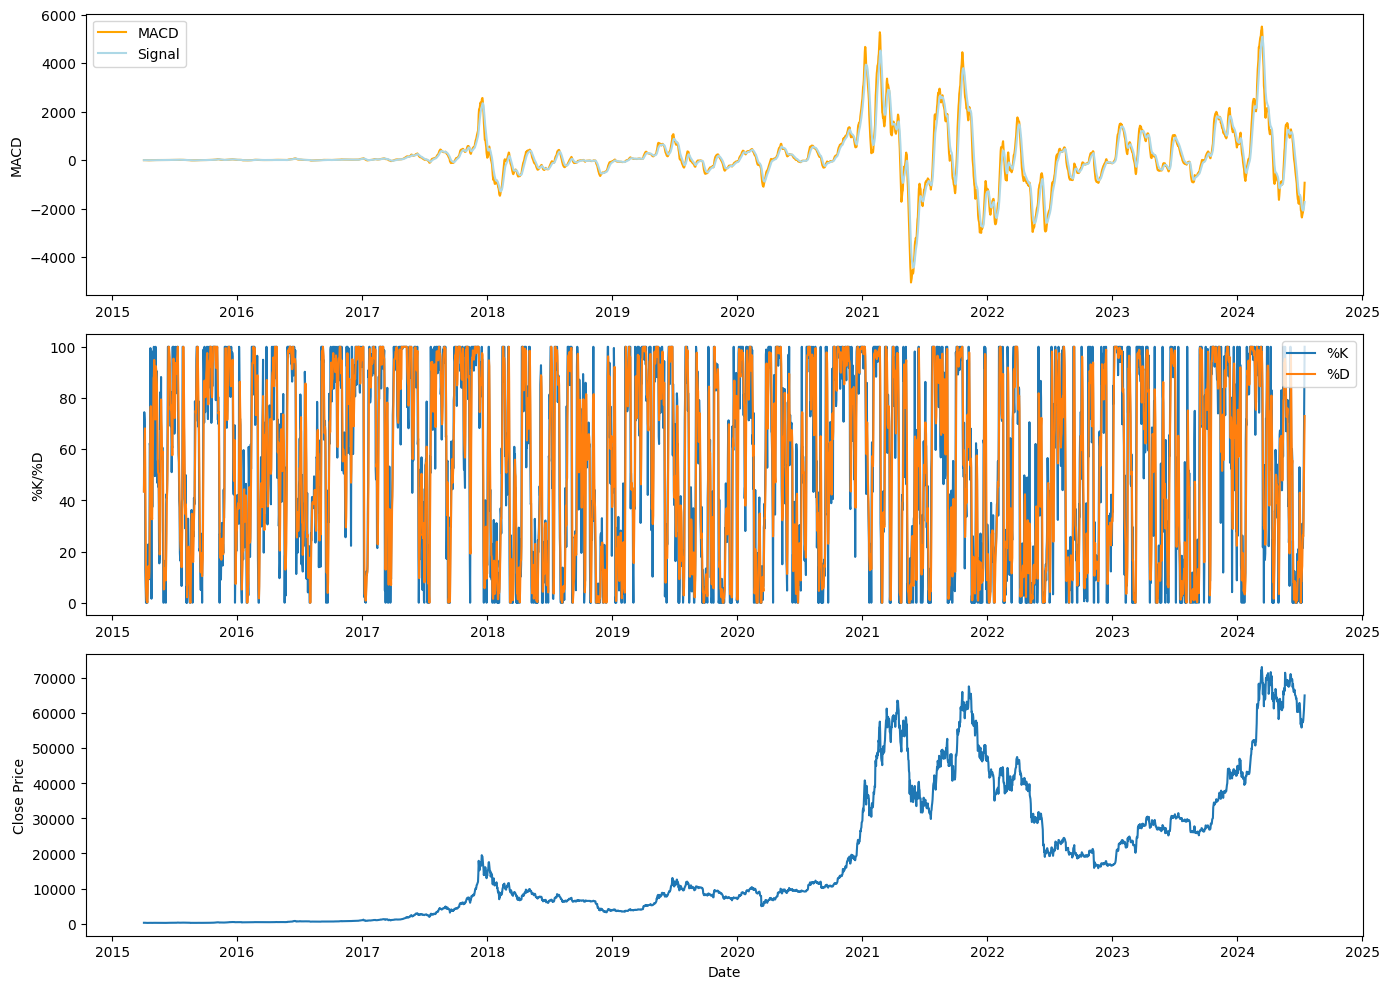

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

ax1.plot(tech_data.index, tech_data['MACD'], label='MACD', c = 'orange')
ax1.plot(tech_data.index, tech_data['Signal'], label='Signal', c = 'lightblue')
ax1.set_ylabel('MACD')
ax1.legend()

ax2.plot(tech_data.index, tech_data['%K'], label='%K')
ax2.plot(tech_data.index, tech_data['%D'], label='%D')
ax2.set_ylabel('%K/%D')
ax2.legend()

ax3.plot(tech_data.index, tech_data['Close'], label='Close Price')
ax3.set_ylabel('Close Price')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### Visualization Analysis
While it is hard to see when the MACD and Signal lines cross each other, the indicator responds to our data well. When the MACD is >0 we see an upwards trend in Bitcoin prices, and vice versa. Analyzing stochastic oscillator over a ten year period is challenging due to the volatile nature of this indicator.

### Correlations

In [13]:
# Finding the correlations between Close Price, Volume, SMA, EMA, and RSI.
correlation = tech_data[['Close', 'Volume', 'SMA', 'EMA', 'RSI', '%K', 'MACD']].corr()
print(correlation)

           Close    Volume       SMA       EMA       RSI        %K      MACD
Close   1.000000  0.628892  0.911937  0.937988 -0.033234 -0.031298  0.233249
Volume  0.628892  1.000000  0.550125  0.574628  0.007950 -0.015255  0.212619
SMA     0.911937  0.550125  1.000000  0.994746 -0.181024 -0.138703 -0.050984
EMA     0.937988  0.574628  0.994746  1.000000 -0.174771 -0.136513 -0.029579
RSI    -0.033234  0.007950 -0.181024 -0.174771  1.000000  0.685078  0.565389
%K     -0.031298 -0.015255 -0.138703 -0.136513  0.685078  1.000000  0.374289
MACD    0.233249  0.212619 -0.050984 -0.029579  0.565389  0.374289  1.000000


<Axes: >

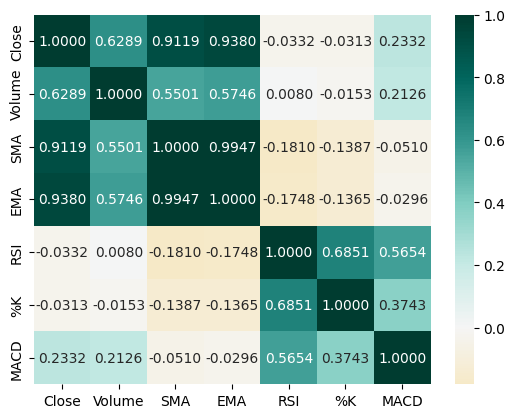

In [14]:
import seaborn as sns
# Visualizing the correlations as a heatmap
sns.heatmap(correlation, fmt=".4f", center = 0, cmap = "BrBG", annot = True)

#### Heatmap Analysis  
As expected, SMA and EMA have an extremely high correlation coefficient with closing prices. This means that both SMA and EMA are useful predictors. RSI, MACD, and the Stochastic Oscillator do not correlate much with the close price, which is expected. RSI, MACD, and Stochastic Oscillators are used to measure the trend of the price, not the price itself. Interestingly, the volume and close also have a relatively high correlation coefficient of 0.64. The law of supply and demand can explain this; when demand goes up, price does too. A higher volume cap signifies greater investor interest, which can increase prices.

## Data Preparation for KNN

### Lagged Features  
Since we are trying to use KNN regression for the prediction of BTC price we will have to create lagged features. We want KNN to predict the price of BTC using only knowledge from previous days.

In [15]:
test_data = cleaned_data.iloc[:, [0, 1, 2, 3, 4, 5]]
#SMA_PERIODS = [10, 20, 50, 100, 200]
#EMA_PERIODS = [10, 20, 50, 100, 200]
#RSI_PERIODS = [7, 14, 21]
test_data = test_data.assign(SMA = tech_data.pipe(calcSMA,10)) # Slight period optimization was done looking at common periods.
test_data = test_data.assign(EMA = tech_data.pipe(calcEMA,20, 'Close'))
test_data = test_data.assign(RSI = tech_data.pipe(calcRSI,14))

test_data.head()
test_data.dropna(inplace = True)

In [16]:
# Create lagged features
def create_lagged_close(df, lag=1):
    new_df = pd.DataFrame(index=df.index)
    for i in range(1, lag + 1):
        new_df[f'Close Lag {i}'] = df['Close'].shift(i)
        #new_df[f'%_change_lag_{i}'] = df['% Gain/Loss'].shift(i)
    return new_df

def create_lagged_volume(df, lag=1):
    new_df = pd.DataFrame(index=df.index)
    for i in range(1, lag + 1):
        new_df[f'Volume Lag{i}'] = df['Volume'].shift(i)
    return new_df

# Create lagged features
lagged_close = create_lagged_close(test_data,lag=10)
lagged_volume = create_lagged_volume(test_data,lag=10)

# Drop rows with NaN values resulting from lagging
lagged_close.dropna(inplace=True)
lagged_volume.dropna(inplace=True)
lagged_close.head()

,Close Lag 1,Close Lag 2,Close Lag 3,Close Lag 4,Close Lag 5,Close Lag 6,Close Lag 7,Close Lag 8,Close Lag 9,Close Lag 10
Date,,,,,,,,,,
2015-04-27,219.429993,226.389999,231.268005,236.462006,234.175995,235.268997,224.626007,222.600006,223.356003,222.882004
2015-04-28,229.285995,219.429993,226.389999,231.268005,236.462006,234.175995,235.268997,224.626007,222.600006,223.356003
2015-04-29,225.854996,229.285995,219.429993,226.389999,231.268005,236.462006,234.175995,235.268997,224.626007,222.600006
2015-04-30,225.807999,225.854996,229.285995,219.429993,226.389999,231.268005,236.462006,234.175995,235.268997,224.626007
2015-05-01,236.145004,225.807999,225.854996,229.285995,219.429993,226.389999,231.268005,236.462006,234.175995,235.268997


In [17]:
def create_lagged_indicator(df, lag=1):
    new_df = pd.DataFrame(index=df.index)
    for i in range(1, lag + 1):
        new_df[f'SMA Lag {i}'] = df['SMA'].shift(i)
    for i in range(1, lag + 1):
        new_df[f'EMA Lag {i}'] = df['EMA'].shift(i)
    for i in range(1, lag + 1):
        new_df[f'RSI Lag {i}'] = df['RSI'].shift(i)
    return new_df

# Create lagged features
lagged_indicators = create_lagged_indicator(test_data,lag=10) # We chose a value of ten so that the KNN model could see the data from the ten previous days.

# Drop rows with NaN values resulting from lagging
lagged_indicators.dropna(inplace=True)
lagged_indicators.head()

,SMA Lag 1,SMA Lag 2,SMA Lag 3,SMA Lag 4,SMA Lag 5,SMA Lag 6,SMA Lag 7,SMA Lag 8,SMA Lag 9,SMA Lag 10,...,RSI Lag 1,RSI Lag 2,RSI Lag 3,RSI Lag 4,RSI Lag 5,RSI Lag 6,RSI Lag 7,RSI Lag 8,RSI Lag 9,RSI Lag 10
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-27,227.645901,228.560202,228.304501,227.093601,225.906101,226.103801,226.232102,227.376701,229.484300,231.650900,...,37.409083,41.510158,45.668168,43.765995,40.472583,36.003747,22.269736,17.652467,26.617227,26.077154
2015-04-28,228.286301,227.645901,228.560202,228.304501,227.093601,225.906101,226.103801,226.232102,227.376701,229.484300,...,53.631422,37.409083,41.510158,45.668168,43.765995,40.472583,36.003747,22.269736,17.652467,26.617227
2015-04-29,228.536200,228.286301,227.645901,228.560202,228.304501,227.093601,225.906101,226.103801,226.232102,227.376701,...,55.339541,53.631422,37.409083,41.510158,45.668168,43.765995,40.472583,36.003747,22.269736,17.652467
2015-04-30,228.856999,228.536200,228.286301,227.645901,228.560202,228.304501,227.093601,225.906101,226.103801,226.232102,...,51.700392,55.339541,53.631422,37.409083,41.510158,45.668168,43.765995,40.472583,36.003747,22.269736
2015-05-01,230.008899,228.856999,228.536200,228.286301,227.645901,228.560202,228.304501,227.093601,225.906101,226.103801,...,55.946103,51.700392,55.339541,53.631422,37.409083,41.510158,45.668168,43.765995,40.472583,36.003747


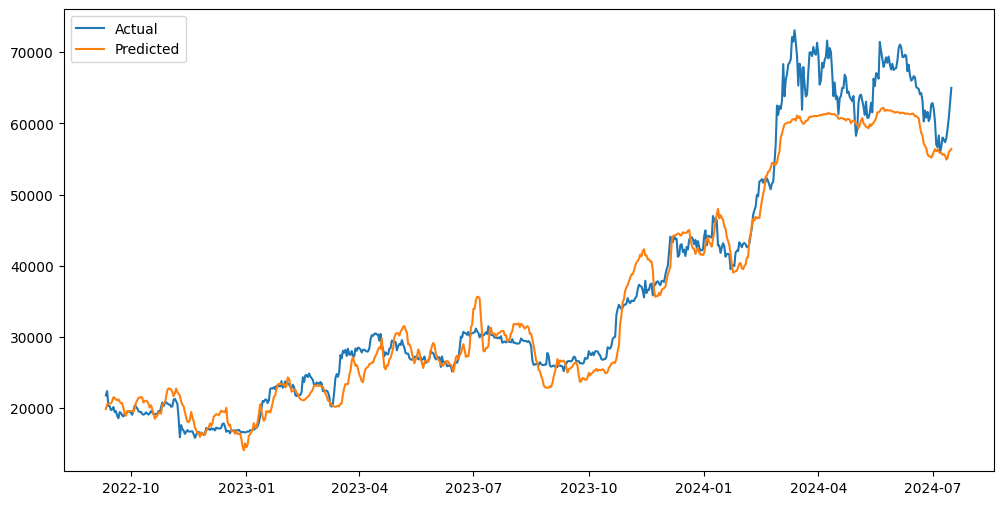

Mean Squared Error: 11769323.06808892
Root Mean Squared Error: 3430.6447015231583
Mean Absolute Error: 2538.277662978615
Percent Error: 6.730993378670218%
R^2: 95.93124671861798%


In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Merge data
training_data = pd.merge(cleaned_data.iloc[:, [3]], lagged_close, on='Date')
training_data = pd.merge(test_data[['RSI']], training_data, on='Date')
training_data = pd.merge(training_data, lagged_indicators, on='Date')
training_data = pd.merge(training_data, lagged_volume, on='Date')
# Separate features and target
close_training_data = training_data.drop(['RSI'], axis=1)
features = close_training_data.drop(['Close'], axis=1)
target = close_training_data['Close']

# Split data into train and test sets
train_size = int(len(training_data) * 0.8)
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Create pipeline
pipeline = make_pipeline(MinMaxScaler(), KNeighborsRegressor(n_neighbors=29))

# Fit model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Create DataFrame for predictions
prediction_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted Close'])
prediction_df['Actual Close'] = y_test

# Drop NaN values if any
prediction_df = prediction_df.dropna()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
percent_error = np.mean(np.abs(prediction_df['Predicted Close'] - prediction_df['Actual Close']) / prediction_df['Actual Close'] * 100)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Percent Error: {percent_error}%')
print(f'R^2: {r2 * 100}%')

### Model Analysis  
Root Mean Squared Error (RMSE): An RMSE of \\$3430 indicate that, on average, accounting for squared differences, the model's predictions are off by \\$3430.

Percent Error: A percent error of 6.73% indicates that, on average, the model's predictions are off by 6.73%.

r<sup>2</sup>: An r<sup>2</sup> value of 95.93% indicates that this model captures 95.93% of the variability in BTC prices. This suggests that the model fits the data well.

Mean Absolute Error (MAE): A Mean Absolute Error of \\$2538.27 indicate that, on averaeg, the model's predictions are off by \\$2538.27. We did not implement cross-validation since our data is a time-series using lagged features requiring it to use other methods of cross-validation.

## Conclusion

### KNN Regression

We attempted to predict the price of Bitcoin by using a time series KNN Regression model. KNN Regression is not the best model for predicting time series data as KNN does not inherently capture the temporal dependencies in time series data. We attempted to get around this by adding ten days of lag to each observation, effectively adding past data as features. This allowed our model to access past historical data and trends to attempt to predict the price of Bitcoin. Our model could accurately follow the market trends but would need to be more accurate to trust in buying Bitcoin (if extrapolation error did not exist).

***

## Long Short-Term Memory Regression (LSTM) using TensorFlow

In [19]:
%%capture
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install tensorflow keras scikeras --upgrade

In [20]:
tech_data = tech_data.assign(RSI = tech_data.pipe(calcRSI,7)) # We will be using a window of 21 days for visualization purposes.
tech_data = tech_data.assign(SMA = tech_data.pipe(calcSMA,50)) # Window of 200 for visualization purposes.
tech_data = tech_data.assign(EMA = tech_data.pipe(calcEMA,50, 'Close')) # Window of 200 for visualization purposes
tech_data = tech_data.assign(Signal = tech_data.pipe(calcEMA,9, 'MACD'))

tech_data

,Open,High,Low,Close,Volume,Price Gap,SMA,EMA,RSI,MACD,Signal,%K,%D
Date,,,,,,,,,,,,,
2015-04-04,254.291000,255.257996,251.100006,253.697006,1.249350e+07,0.593994,NaN,253.697006,NaN,-4.193133,-4.193133,43.506205,43.417744
2015-04-05,253.761002,260.674988,251.942001,260.597992,1.964920e+07,-6.836990,NaN,253.967633,NaN,-3.252122,-4.004931,74.437092,54.641682
2015-04-06,260.721008,261.798004,254.574997,255.492004,2.003420e+07,5.229004,NaN,254.027412,NaN,-2.885117,-3.780968,71.450996,63.131431
2015-04-07,255.274002,255.804993,252.205002,253.179993,1.846740e+07,2.094009,NaN,253.994180,NaN,-2.749132,-3.574601,58.523897,68.137328
2015-04-08,253.063995,253.847000,244.214996,245.022003,3.008640e+07,8.041992,NaN,253.642330,NaN,-3.262042,-3.512089,12.910297,47.628397
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-11,57729.890625,59299.433594,57120.378906,57344.914063,2.870780e+10,384.976562,64699.966563,62667.606983,52.537616,-2168.363770,-2082.731820,21.359878,26.414445
2024-07-12,57341.195313,58532.554688,56590.175781,57899.464844,2.560481e+10,-558.269531,64499.364610,62480.621017,58.275320,-2061.262024,-2078.437861,29.278784,25.891984
2024-07-13,57908.738281,59787.078125,57796.441406,59231.953125,1.708006e+10,-1323.214844,64313.481641,62353.222276,56.478002,-1847.564873,-2032.263264,48.306526,32.981729


In [21]:
# 20-day Simple Moving Average
tech_data['20d SMA'] = tech_data['Close'].rolling(window=20).mean()

# 20-period Standard Deviation
tech_data['20d SD'] = tech_data['Close'].rolling(window=20).std()

# Upper and Lower Bollinger Bands
tech_data['Upper Band'] = tech_data['20d SMA'] + 2 * tech_data['20d SD']
tech_data['Lower Band'] = tech_data['20d SMA'] - 2 * tech_data['20d SD']

tech_data.dropna(inplace = True)

In [22]:
from sklearn.preprocessing import StandardScaler

# Running Standard Scaler (Z-Score Scaling)
scaler_features = StandardScaler()
scaled_features = scaler_features.fit_transform(tech_data.drop(columns=["Close"]))
scaled_features = pd.DataFrame(scaled_features, index=tech_data.index, columns=tech_data.drop(columns=["Close"]).columns)

scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(tech_data[["Close"]])
scaled_target = pd.DataFrame(scaled_target, index=tech_data.index, columns=["Close"])

scaled_features = scaled_features.drop(["Open", "High", "Low", "Price Gap"], axis='columns')

scaled_features

,Volume,SMA,EMA,RSI,MACD,Signal,%K,%D,20d SMA,20d SD,Upper Band,Lower Band
Date,,,,,,,,,,,,
2015-05-23,-0.967600,-0.950306,-0.956627,0.187824,-0.119919,-0.128363,0.329214,0.110298,-0.948706,-0.805944,-0.954866,-0.933034
2015-05-24,-0.967760,-0.950319,-0.956621,0.331707,-0.119622,-0.128271,0.885045,0.688842,-0.948701,-0.805890,-0.954855,-0.933037
2015-05-25,-0.967609,-0.950345,-0.956623,0.306243,-0.119683,-0.128210,0.015979,0.437422,-0.948698,-0.805901,-0.954854,-0.933032
2015-05-26,-0.967505,-0.950365,-0.956625,0.496107,-0.119735,-0.128172,0.044920,0.336391,-0.948679,-0.806281,-0.954883,-0.932953
2015-05-27,-0.967380,-0.950382,-0.956627,0.306977,-0.119768,-0.128149,0.095495,0.055803,-0.948679,-0.806280,-0.954883,-0.932953
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-11,0.522902,2.528552,2.436231,-0.070786,-2.149372,-2.179157,-0.937875,-0.852701,2.216297,1.157414,2.141166,2.290182
2024-07-12,0.361713,2.517726,2.426069,0.164698,-2.049142,-2.174929,-0.721901,-0.867893,2.199453,1.018609,2.108848,2.292579
2024-07-13,-0.081115,2.507695,2.419145,0.090933,-1.849158,-2.129464,-0.202952,-0.661745,2.188983,0.898632,2.084601,2.299203


In [23]:
import numpy as np

# Function to create sequences
def create_sequences(data, target, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(target[i])
    return np.array(x), np.array(y)

# Set sequence length
seq_length = 60

# Create sequences
x, y = create_sequences(scaled_features.values, scaled_target.values, seq_length)

# Split the data into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Keep track of the corresponding dates for x_test
dates = scaled_target.index[seq_length + train_size: seq_length + train_size + len(x_test)]

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (2625, 60, 12)
y_train shape: (2625, 1)
x_test shape: (657, 60, 12)
y_test shape: (657, 1)


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the LSTM model
model = Sequential()
model.add(Input(shape=(seq_length, 12)))  # Specify input shape here AKA NUMBER OF FEATURES

model.add(LSTM(units=50, activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=50, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=50, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00005)

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - loss: 0.4084 - val_loss: 1.0238 - learning_rate: 0.0010
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1840 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1440 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1319 - val_loss: 0.6223 - learning_rate: 0.0010
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1289 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1275 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1217 - val_loss: 0.4182 - learning_rate: 0.0010
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1069 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1109 - val_loss: 0.4598 - learning_rate: 0.0010
Epoch 10/50
66/66

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,755 (858.42 KB)

 Trainable params: 73,251 (286.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,504 (572.29 KB)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Mean Squared Error: 28689015.8062939
Root Mean Squared Error: 5356.212823095615
Mean Absolute Error: 3580.9552505953197
R^2: 90.09406034191457%


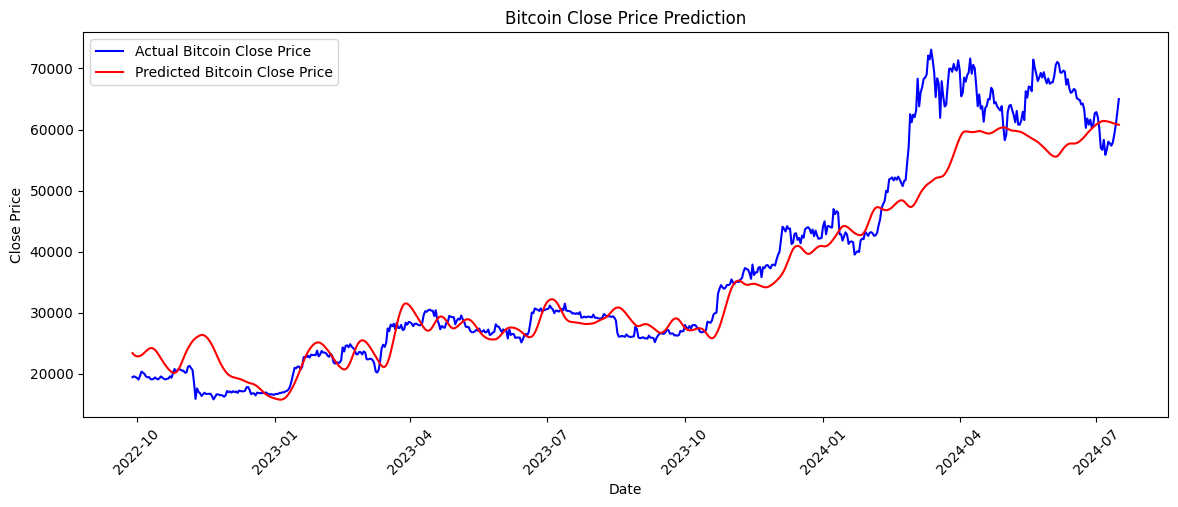

In [26]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(x_test)

# Inverse transform predictions and actual values (adjusting for Z-Score Scaling)
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2 * 100}%')
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_inv, color='blue', label='Actual Bitcoin Close Price')
plt.plot(dates, y_pred_inv, color='red', label='Predicted Bitcoin Close Price')
plt.title('Bitcoin Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Optimizing and Fixing Data Preprocessing

In [27]:
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [28]:
# Load and preprocess the data
data = pd.DataFrame(index=tech_data.index)

data['Close'] = tech_data['Close']

# Technical Analysis
data['RSI'] = tech_data.pipe(calcRSI,7)
data['SMA'] = tech_data.pipe(calcSMA,50)
data['EMA'] = tech_data.pipe(calcEMA,50, 'Close')
data['MACD'] = tech_data.pipe(calcEMA,9, 'MACD')
data['Signal'] = tech_data['Signal']
data['20d SMA'] = tech_data['20d SMA']
data['20d SD'] = tech_data['20d SD']
data['Upper Band'] = tech_data['Upper Band']
data['Lower Band'] = tech_data['Lower Band']

data.dropna(inplace = True)
data

,Close,RSI,SMA,EMA,MACD,Signal,20d SMA,20d SD,Upper Band,Lower Band
Date,,,,,,,,,,
2015-07-11,293.114990,84.465834,244.565059,250.998706,8.028379,8.028376,259.737899,14.134930,288.007759,231.468039
2015-07-12,310.867004,86.419225,246.004959,253.346482,9.061692,9.061690,262.931749,17.835198,298.602146,227.261352
2015-07-13,292.053986,66.585489,247.026979,254.864423,9.943598,9.943597,265.319648,18.397031,302.113710,228.525586
2015-07-14,287.463989,64.932477,248.034059,256.142838,10.588481,10.588480,267.667097,18.057591,303.782279,231.551916
2015-07-15,285.829010,61.023833,249.008319,257.307001,11.000778,11.000777,269.818598,17.493320,304.805238,234.831958
...,...,...,...,...,...,...,...,...,...,...
2024-07-11,57344.914063,52.537616,64699.966563,62667.606983,-2082.731820,-2082.731820,59923.334766,2537.538865,64998.412495,54848.257036
2024-07-12,57899.464844,58.275320,64499.364610,62480.621017,-2078.437861,-2078.437861,59605.679102,2358.395588,64322.470279,54888.887925
2024-07-13,59231.953125,56.478002,64313.481641,62353.222276,-2032.263264,-2032.263264,59408.236914,2203.550973,63815.338861,55001.134968


In [29]:
scaler_features = StandardScaler()
scaled_features = scaler_features.fit_transform(data.drop(columns=["Close"]))
scaled_features = pd.DataFrame(scaled_features, index=data.index, columns=data.drop(columns=["Close"]).columns)

scaler_target = StandardScaler()
scaled_target = scaler_target.fit_transform(data[["Close"]])
scaled_target = pd.DataFrame(scaled_target, index=data.index, columns=["Close"])

scaled_features

,RSI,SMA,EMA,MACD,Signal,20d SMA,20d SD,Upper Band,Lower Band
Date,,,,,,,,,
2015-07-11,1.243355,-0.963349,-0.969640,-0.121555,-0.121555,-0.961021,-0.807668,-0.966455,-0.946036
2015-07-12,1.323606,-0.963272,-0.969512,-0.120545,-0.120545,-0.960851,-0.804808,-0.965949,-0.946284
2015-07-13,0.508775,-0.963216,-0.969430,-0.119683,-0.119683,-0.960725,-0.804374,-0.965781,-0.946209
2015-07-14,0.440865,-0.963162,-0.969360,-0.119053,-0.119053,-0.960601,-0.804637,-0.965701,-0.946031
2015-07-15,0.280286,-0.963110,-0.969297,-0.118650,-0.118650,-0.960487,-0.805073,-0.965652,-0.945837
...,...,...,...,...,...,...,...,...,...
2024-07-11,-0.068354,2.512850,2.420714,-2.165262,-2.165262,2.200763,1.142531,2.125772,2.274333
2024-07-12,0.167368,2.502032,2.410557,-2.161065,-2.161065,2.183929,1.004081,2.093472,2.276729
2024-07-13,0.093529,2.492007,2.403637,-2.115930,-2.115930,2.173466,0.884410,2.069238,2.283347


In [30]:
import numpy as np

# Function to create sequences
def create_sequences(data, target, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(target[i])
    return np.array(x), np.array(y)

# Set sequence length
seq_length = 60

# Create sequences
x, y = create_sequences(scaled_features.values, scaled_target.values, seq_length)

# Split the data into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Keep track of the corresponding dates for x_test
dates = scaled_target.index[seq_length + train_size: seq_length + train_size + len(x_test)]

In [ ]:
def create_model(optimizer = "adam", units = "25"):
    model = Sequential()
    model.add(Input(shape=(seq_length, 9)))  # Specify input shape here AKA NUMBER OF FEATURES
    model.add(LSTM(units, activation = 'relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units, activation = 'relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model

model = KerasRegressor(build_fn=create_model, epochs=30, batch_size=16, verbose=0, units=25)

param_grid = {
    'optimizer': ['adam', 'sgd'],
    'units': [25, 50, 75, 100],
    'batch_size': [16, 32, 64, 128],
    'epochs': [30, 50, 70, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)

# Display best parameters
print(f'Best parameters: {grid_result.best_params_}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [ ]:
# Train the best model
best_estimator = grid_result.best_estimator_

# Fit the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = best_estimator.fit(
    x_train, y_train,
    epochs=grid_result.best_params_['epochs'],
    batch_size=grid_result.best_params_['batch_size'],
    validation_split=0.2,
    callbacks=[reduce_lr]
)

# Make predictions
y_pred = best_estimator.predict(x_test)

In [ ]:
# Inverse transform the predictions and actual values
y_pred_inv = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2: {r2 * 100}%')

In [ ]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_inv, color='blue', label='Actual Bitcoin Close Price')
plt.plot(dates, y_pred_inv, color='red', label='Predicted Bitcoin Close Price')
plt.title('Bitcoin Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()
